# Pre Processing


In [ ]:
!pip uninstall -y torchtext
!pip install torchtext==0.16.0 torch==2.1.0 --upgrade


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 63.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import re
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from collections import Counter


In [ ]:
# Load dataset
df = pd.read_csv('/content/train.csv', encoding='ISO-8859-1').dropna(subset=['text', 'sentiment'])


In [ ]:
# Remove neutral sentiments
df = df[df['sentiment'] != 'neutral']

In [ ]:
# Encode sentiment labels (0-negative, 1-positive)
df['label'] = df['sentiment'].map({'negative': 0, 'positive': 1})

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.strip()  # Remove extra spaces
    return text

In [ ]:
# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

In [ ]:
# Tokenizer
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [ ]:
# Text preprocessing function
def preprocess_text(text):
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'[^\w\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove digits
    text = text.strip()  # Remove extra spaces
    return text

# Apply preprocessing
df['text'] = df['text'].apply(preprocess_text)

# Verify cleaning
print(df['text'].head())

# Tokenizer
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

# Tokenize and build vocabulary (Corrected)
counter = Counter()
for text in df['text']:
    counter.update(tokenizer(text))

# Explicitly include <unk> in the vocabulary
vocab = torchtext.vocab.vocab(counter, min_freq=2, specials=['<unk>'])
vocab.set_default_index(vocab['<unk>'])

# Verify vocabulary creation
print(f"Vocabulary Size: {len(vocab)}")
print(list(vocab.get_stoi().items())[:10])  # Show first 10 vocab items


1           sooo sad i will miss you here in san diego
2                               my boss is bullying me
3                        what interview leave me alone
4    sons of  why couldnt they put them on the rele...
6    am feedings for the baby are fun when he is al...
Name: text, dtype: object
Vocabulary Size: 7131
[('mulch', 7130), ('psy', 7127), ('allianz', 7126), ('macadamia', 7123), ('colossal', 7122), ('parks', 7121), ('hayes', 7120), ('dreamed', 7119), ('valid', 7118), ('placements', 7115)]


In [ ]:
# Define dataset class
class TwitterDataset(Dataset):
    def __init__(self, texts, labels, vocab, tokenizer, max_length=50):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        tokens = self.tokenizer(self.texts[idx])[:self.max_length]
        ids = [self.vocab[token] for token in tokens]
        padding = [self.vocab['<pad>']] * (self.max_length - len(ids))
        return torch.tensor(ids + padding), torch.tensor(self.labels[idx])

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.2, random_state=1234
)

In [ ]:
# Create datasets and loaders
train_dataset = TwitterDataset(X_train.tolist(), y_train.tolist(), vocab, tokenizer)
test_dataset = TwitterDataset(X_test.tolist(), y_test.tolist(), vocab, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


# **CNN**

In [ ]:
pip install numpy==1.23.5  # Example version known to work well with PyTorch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 68.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.5 which is incompatible.
imbalanced-learn 0.13.0 requires numpy<3,>=1.24.3, but you have numpy 1.23.5 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.5 which is incompatible.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.1.0 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
scikit-image 0.25.2 requires numpy>=1.24, but you have numpy 1.23.5 which is incompatible.
bigframes 2.1.0 requires numpy>=1.24.0, but you

In [ ]:
import numpy as np
print(np.__version__)


1.23.5


In [ ]:
# 1. Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# 2. Define the CNN model
class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes, num_filters, kernel_size):
        super(CNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])
        self.conv = nn.Conv1d(embed_dim, num_filters, kernel_size=kernel_size, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)
        self.fc = nn.Linear(num_filters, num_classes)

    def forward(self, x):
        x = self.embedding(x).permute(0, 2, 1)
        x = self.relu(self.conv(x))
        x = self.pool(x).squeeze(2)
        return self.fc(x)

# 3. Training + Evaluation Function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_evaluate_model(embed_dim, num_filters, kernel_size, learning_rate):
    model = CNN(len(vocab), embed_dim, 2, num_filters, kernel_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(2):
        model.train()
        total_loss, correct = 0, 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        print(f"Epoch {epoch+1} - Loss: {total_loss/len(train_loader):.4f}, Accuracy: {correct/len(train_dataset):.4f}")

    # Test evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            correct += (outputs.argmax(1) == labels).sum().item()

    test_accuracy = correct / len(test_dataset)
    return model, test_accuracy

# 4. Hyperparameter tuning
hyperparameters = {
    'embed_dim': [128, 256],
    'num_filters': [50, 200],
    'kernel_size': [3, 5],
    'learning_rate': [0.001,0.0001]
}

best_accuracy = 0
best_params = {}
best_model = None

for embed_dim in hyperparameters['embed_dim']:
    for num_filters in hyperparameters['num_filters']:
        for kernel_size in hyperparameters['kernel_size']:
            for lr in hyperparameters['learning_rate']:
                print(f"Trying: embed_dim={embed_dim}, num_filters={num_filters}, kernel_size={kernel_size}, lr={lr}")
                model, test_acc = train_evaluate_model(embed_dim, num_filters, kernel_size, lr)
                if test_acc > best_accuracy:
                    best_accuracy = test_acc
                    best_model = model
                    best_params = {
                        'embed_dim': embed_dim,
                        'num_filters': num_filters,
                        'kernel_size': kernel_size,
                        'learning_rate': lr
                    }
                    torch.save(model.state_dict(), 'best_model.pth')

print(f"\n✅ Best Accuracy: {best_accuracy:.4f} with params: {best_params}")


Trying: embed_dim=128, num_filters=50, kernel_size=3, lr=0.001
Epoch 1 - Loss: 0.4637, Accuracy: 0.7706
Epoch 2 - Loss: 0.2869, Accuracy: 0.8820
Trying: embed_dim=128, num_filters=50, kernel_size=3, lr=0.0001
Epoch 1 - Loss: 0.6762, Accuracy: 0.6063
Epoch 2 - Loss: 0.5532, Accuracy: 0.7293
Trying: embed_dim=128, num_filters=50, kernel_size=5, lr=0.001
Epoch 1 - Loss: 0.4915, Accuracy: 0.7501
Epoch 2 - Loss: 0.2801, Accuracy: 0.8875
Trying: embed_dim=128, num_filters=50, kernel_size=5, lr=0.0001
Epoch 1 - Loss: 0.6422, Accuracy: 0.6257
Epoch 2 - Loss: 0.5461, Accuracy: 0.7423
Trying: embed_dim=128, num_filters=200, kernel_size=3, lr=0.001
Epoch 1 - Loss: 0.4550, Accuracy: 0.7743
Epoch 2 - Loss: 0.2354, Accuracy: 0.9103
Trying: embed_dim=128, num_filters=200, kernel_size=3, lr=0.0001
Epoch 1 - Loss: 0.6113, Accuracy: 0.6627
Epoch 2 - Loss: 0.4843, Accuracy: 0.7843
Trying: embed_dim=128, num_filters=200, kernel_size=5, lr=0.001
Epoch 1 - Loss: 0.4723, Accuracy: 0.7610
Epoch 2 - Loss: 0.21

In [ ]:
# 5. Reload best model
model = CNN(len(vocab), best_params['embed_dim'], 2, best_params['num_filters'], best_params['kernel_size']).to(device)
model.load_state_dict(torch.load('best_model.pth'))
model.eval()


CNN(
  (embedding): Embedding(7131, 128, padding_idx=0)
  (conv): Conv1d(128, 200, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (pool): AdaptiveMaxPool1d(output_size=1)
  (fc): Linear(in_features=200, out_features=2, bias=True)
)

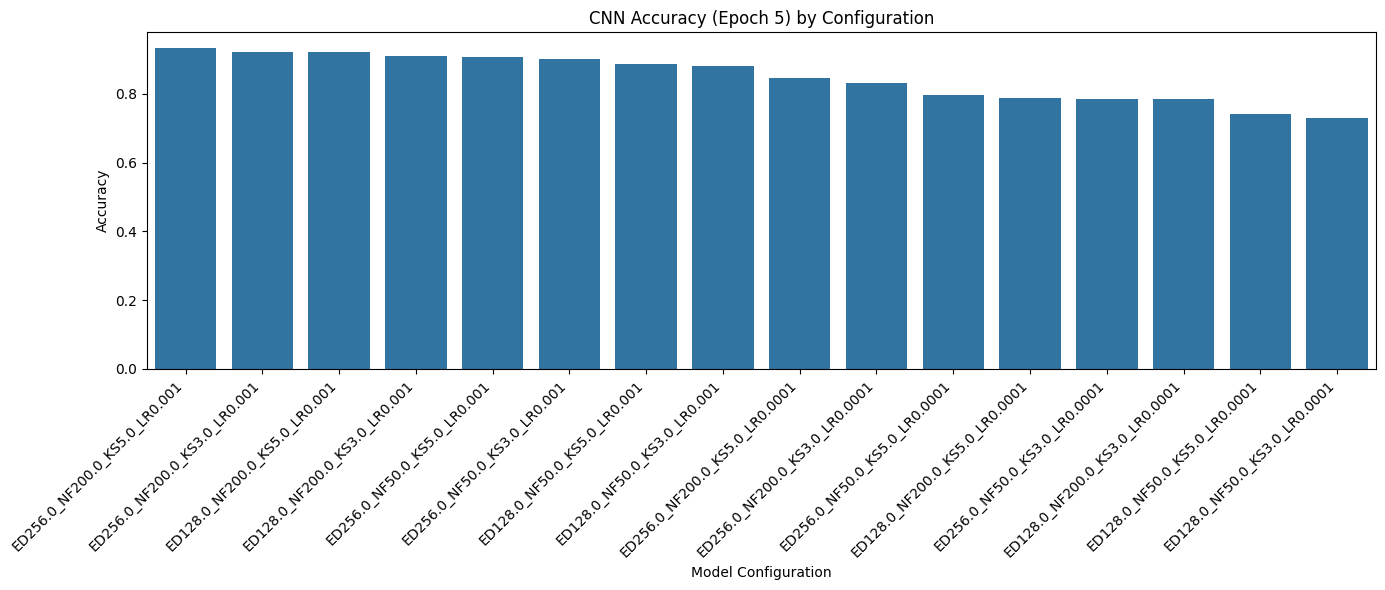

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

cnn_results = [
    (128, 50, 3, 0.001, 0.8820),
    (128, 50, 3, 0.0001, 0.7293),
    (128, 50, 5, 0.001, 0.8875),
    (128, 50, 5, 0.0001, 0.7423),
    (128, 200, 3, 0.001, 0.9103),
    (128, 200, 3, 0.0001, 0.7843),
    (128, 200, 5, 0.001, 0.9211),
    (128, 200, 5, 0.0001, 0.7869),
    (256, 50, 3, 0.001, 0.9007),
    (256, 50, 3, 0.0001, 0.7852),
    (256, 50, 5, 0.001, 0.9059),
    (256, 50, 5, 0.0001, 0.7975),
    (256, 200, 3, 0.001, 0.9219),
    (256, 200, 3, 0.0001, 0.8309),
    (256, 200, 5, 0.001, 0.9322),
    (256, 200, 5, 0.0001, 0.8453),
]

df_cnn = pd.DataFrame(cnn_results, columns=["embed_dim", "num_filters", "kernel_size", "lr", "accuracy"])
df_cnn["config"] = df_cnn.apply(lambda r: f"ED{r.embed_dim}_NF{r.num_filters}_KS{r.kernel_size}_LR{r.lr}", axis=1)

plt.figure(figsize=(14, 6))
sns.barplot(data=df_cnn.sort_values("accuracy", ascending=False), x="config", y="accuracy")
plt.xticks(rotation=45, ha='right')
plt.title("CNN Accuracy (Epoch 5) by Configuration")
plt.xlabel("Model Configuration")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

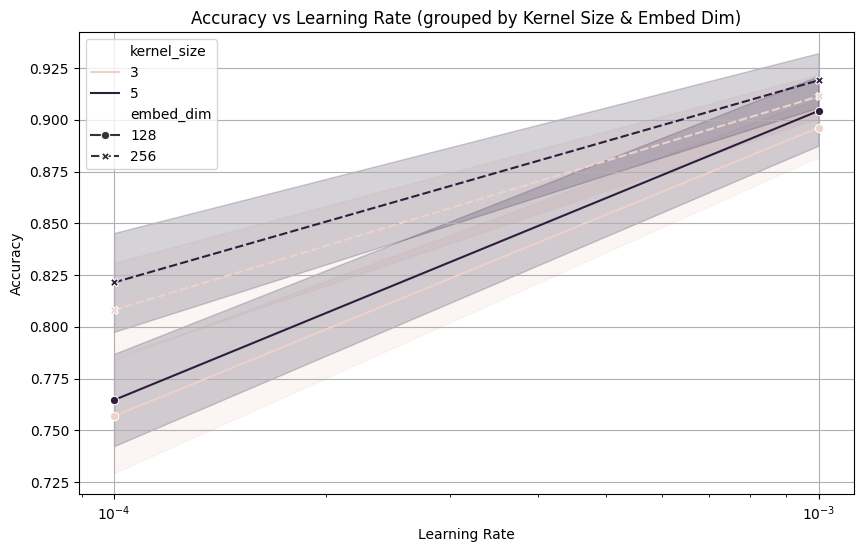

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_cnn, x="lr", y="accuracy", hue="kernel_size", style="embed_dim", markers=True)
plt.title("Accuracy vs Learning Rate (grouped by Kernel Size & Embed Dim)")
plt.xscale("log")
plt.ylabel("Accuracy")
plt.xlabel("Learning Rate")
plt.grid(True)
plt.show()

In [ ]:
def predict_twitter_sentiment(model, tweet, vocab, tokenizer, device, max_length=50):
    model.eval()  # Set model to evaluation mode

    # Tokenize the tweet (already preprocessed text)
    tokens = tokenizer(tweet)[:max_length]  # Ensure no more than max_length tokens

    # Convert tokens to token IDs, using vocab, handle unknown tokens with '<unk>'
    ids = [vocab[token] if token in vocab else vocab['<unk>'] for token in tokens]

    # Pad with '<pad>' tokens if the sequence is shorter than max_length
    padding = [vocab['<pad>']] * (max_length - len(ids))

    # Combine the token IDs with padding and convert to a tensor
    input_tensor = torch.tensor([ids + padding]).to(device)

    # Ensure the tensor shape is (batch_size, sequence_length), i.e., (1, max_length)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

    # Check shape of input_tensor (should be 2D before embedding)
      # This should print (1, max_length)

    # Ensure tensor is correctly shaped for the embedding layer
    input_tensor = input_tensor.view(input_tensor.size(0), -1)  # Flatten the tensor to (batch_size, sequence_length)

    # No gradients needed during prediction
    with torch.no_grad():
        output = model(input_tensor)  # Get model output
        prediction = torch.argmax(output, dim=1).item()  # Get the predicted class (0 or 1)

    return prediction




# Example tweets
tweets = [
    "This phone exceeded all my expectations. Absolutely love it!",
    "The food was cold and tasteless. Not coming back again.",
    "Wow, waited 45 minutes for this masterpiece of disappointment.",
    "The app crashed 3 times, but support fixed it quickly. Mixed feelings.",
    "Nothing special about the movie. Just average.",
    "Amazing product and super fast delivery. 10/10!",
    "Sure, I love wasting my day in traffic. Best day ever!",
    "Customer service was helpful, but I’m still not satisfied.",
    "I’m so happy with my purchase, I’m telling everyone!",
    "Yeah right, like that update really fixed anything."
]

for tweet in tweets:
    pred = predict_twitter_sentiment(model, tweet, vocab, tokenizer, device)
    sentiment = "Positive" if pred == 1 else "Negative"
    print(f"Tweet: {tweet}\nPrediction: {sentiment}\n")


Tweet: This phone exceeded all my expectations. Absolutely love it!
Prediction: Positive

Tweet: The food was cold and tasteless. Not coming back again.
Prediction: Negative

Tweet: Wow, waited 45 minutes for this masterpiece of disappointment.
Prediction: Positive

Tweet: The app crashed 3 times, but support fixed it quickly. Mixed feelings.
Prediction: Negative

Tweet: Nothing special about the movie. Just average.
Prediction: Positive

Tweet: Amazing product and super fast delivery. 10/10!
Prediction: Positive

Tweet: Sure, I love wasting my day in traffic. Best day ever!
Prediction: Positive

Tweet: Customer service was helpful, but I’m still not satisfied.
Prediction: Negative

Tweet: I’m so happy with my purchase, I’m telling everyone!
Prediction: Positive

Tweet: Yeah right, like that update really fixed anything.
Prediction: Positive



# LSTM


In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=1):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers=num_layers,
                            batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # because bidirectional LSTM

    def forward(self, x):
        x = self.embedding(x)
        output, (hidden, cell) = self.lstm(x)
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        return self.fc(hidden)


In [ ]:
# 2. Define the training and evaluation function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_evaluate_model(embed_dim, hidden_dim, num_layers, learning_rate):
    model = LSTMModel(len(vocab), embed_dim, hidden_dim, 2, num_layers).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(2):
        model.train()
        total_loss, correct = 0, 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        accuracy = correct / len(train_loader.dataset)  # Corrected here
        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    # Test evaluation
    model.eval()
    correct = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            correct += (outputs.argmax(1) == labels).sum().item()

    test_accuracy = correct / len(test_loader.dataset)  # Corrected here
    return model, test_accuracy

# 3. Hyperparameter tuning
hyperparameters = {
    'embed_dim': [128, 256],
    'hidden_dim': [128, 256],
    'num_layers': [1, 2],
    'learning_rate': [0.001, 0.0001]
}

best_accuracy = 0
best_params = {}
best_model = None

for embed_dim in hyperparameters['embed_dim']:
    for hidden_dim in hyperparameters['hidden_dim']:
        for num_layers in hyperparameters['num_layers']:
            for lr in hyperparameters['learning_rate']:
                print(f"Trying: embed_dim={embed_dim}, hidden_dim={hidden_dim}, num_layers={num_layers}, lr={lr}")
                model, test_acc = train_evaluate_model(embed_dim, hidden_dim, num_layers, lr)
                if test_acc > best_accuracy:
                    best_accuracy = test_acc
                    best_model = model
                    best_params = {
                        'embed_dim': embed_dim,
                        'hidden_dim': hidden_dim,
                        'num_layers': num_layers,
                        'learning_rate': lr
                    }
                    torch.save(model.state_dict(), 'best_lstm_model.pth')

print(f"\n✅ Best Accuracy: {best_accuracy:.4f} with params: {best_params}")

Trying: embed_dim=128, hidden_dim=128, num_layers=1, lr=0.001
Epoch 1 - Loss: 0.5023, Accuracy: 0.7419
Epoch 2 - Loss: 0.3249, Accuracy: 0.8599
Trying: embed_dim=128, hidden_dim=128, num_layers=1, lr=0.0001
Epoch 1 - Loss: 0.6529, Accuracy: 0.6105
Epoch 2 - Loss: 0.5169, Accuracy: 0.7474
Trying: embed_dim=128, hidden_dim=128, num_layers=2, lr=0.001
Epoch 1 - Loss: 0.4846, Accuracy: 0.7582
Epoch 2 - Loss: 0.3158, Accuracy: 0.8655
Trying: embed_dim=128, hidden_dim=128, num_layers=2, lr=0.0001
Epoch 1 - Loss: 0.6005, Accuracy: 0.6589
Epoch 2 - Loss: 0.4471, Accuracy: 0.7856
Trying: embed_dim=128, hidden_dim=256, num_layers=1, lr=0.001
Epoch 1 - Loss: 0.5013, Accuracy: 0.7458
Epoch 2 - Loss: 0.3341, Accuracy: 0.8546
Trying: embed_dim=128, hidden_dim=256, num_layers=1, lr=0.0001
Epoch 1 - Loss: 0.6116, Accuracy: 0.6630
Epoch 2 - Loss: 0.4893, Accuracy: 0.7630
Trying: embed_dim=128, hidden_dim=256, num_layers=2, lr=0.001
Epoch 1 - Loss: 0.5004, Accuracy: 0.7481
Epoch 2 - Loss: 0.3384, Accura

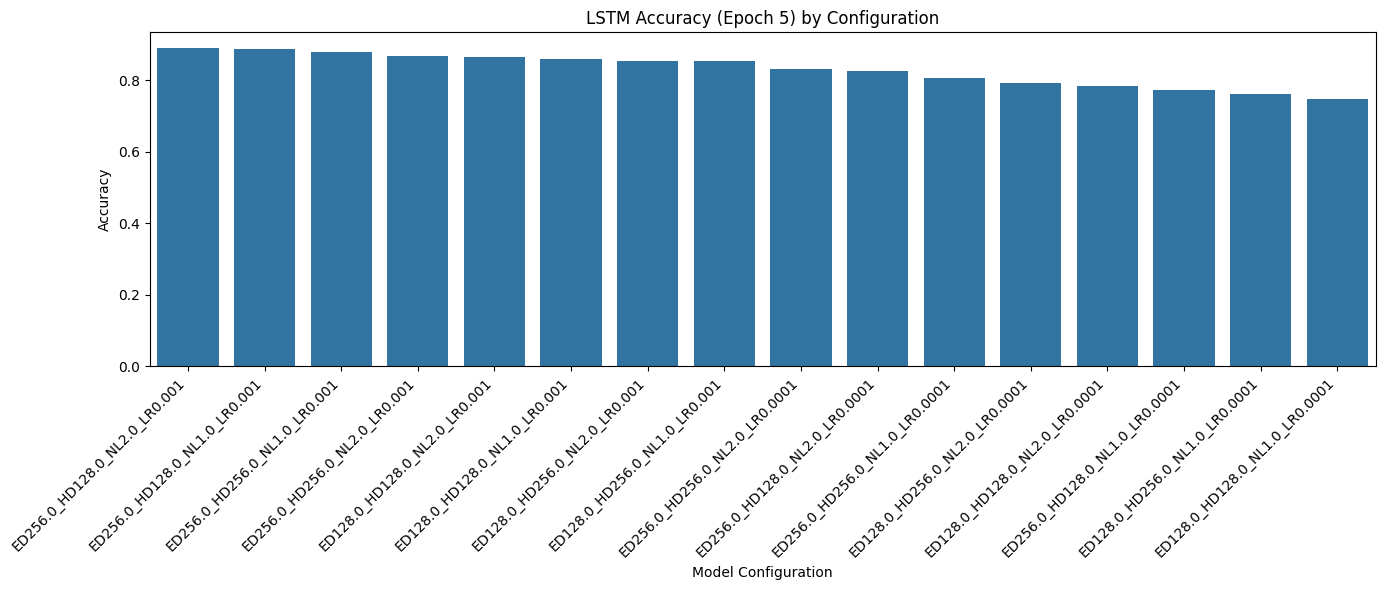

In [ ]:
lstm_results = [
    (128, 128, 1, 0.001, 0.8599),
    (128, 128, 1, 0.0001, 0.7474),
    (128, 128, 2, 0.001, 0.8655),
    (128, 128, 2, 0.0001, 0.7856),
    (128, 256, 1, 0.001, 0.8546),
    (128, 256, 1, 0.0001, 0.7630),
    (128, 256, 2, 0.001, 0.8551),
    (128, 256, 2, 0.0001, 0.7919),
    (256, 128, 1, 0.001, 0.8886),
    (256, 128, 1, 0.0001, 0.7746),
    (256, 128, 2, 0.001, 0.8901),
    (256, 128, 2, 0.0001, 0.8277),
    (256, 256, 1, 0.001, 0.8785),
    (256, 256, 1, 0.0001, 0.8056),
    (256, 256, 2, 0.001, 0.8690),
    (256, 256, 2, 0.0001, 0.8315),
]

df_lstm = pd.DataFrame(lstm_results, columns=["embed_dim", "hidden_dim", "num_layers", "lr", "accuracy"])
df_lstm["config"] = df_lstm.apply(lambda r: f"ED{r.embed_dim}_HD{r.hidden_dim}_NL{r.num_layers}_LR{r.lr}", axis=1)

plt.figure(figsize=(14, 6))
sns.barplot(data=df_lstm.sort_values("accuracy", ascending=False), x="config", y="accuracy")
plt.xticks(rotation=45, ha='right')
plt.title("LSTM Accuracy (Epoch 5) by Configuration")
plt.xlabel("Model Configuration")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()



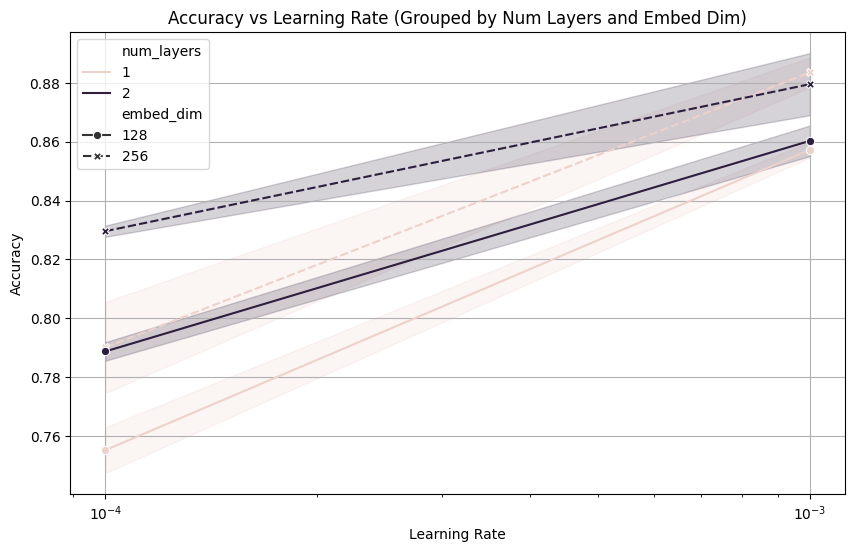

In [ ]:
# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_lstm, x="lr", y="accuracy", hue="num_layers", style="embed_dim", markers=True)
plt.xscale("log")
plt.title("Accuracy vs Learning Rate (Grouped by Num Layers and Embed Dim)")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
def predict_twitter_sentiment(model, tweet, vocab, tokenizer, device):
    model.eval()  # Set the model to evaluation mode
    # Tokenize the tweet and convert it to a tensor of indices using the vocab
    tokens = tokenizer(tweet)  # Assuming tokenizer is defined
    indices = [vocab[token] if token in vocab else vocab['<unk>'] for token in tokens]
    indices = torch.tensor(indices).unsqueeze(0).to(device)  # Add batch dimension and move to device

    # Make prediction
    with torch.no_grad():  # Disable gradient computation for inference
        output = model(indices)
        pred = output.argmax(dim=1).item()  # Get the predicted class label (0 or 1)

    return pred
for tweet in tweets:
    sentiment_pred = predict_twitter_sentiment(best_model, tweet, vocab, tokenizer, device)
    sentiment = "Positive" if sentiment_pred == 1 else "Negative"
    print(f"Tweet: {tweet}\nPrediction: {sentiment}\n")


Tweet: This phone exceeded all my expectations. Absolutely love it!
Prediction: Positive

Tweet: The food was cold and tasteless. Not coming back again.
Prediction: Negative

Tweet: Wow, waited 45 minutes for this masterpiece of disappointment.
Prediction: Positive

Tweet: The app crashed 3 times, but support fixed it quickly. Mixed feelings.
Prediction: Negative

Tweet: Nothing special about the movie. Just average.
Prediction: Positive

Tweet: Amazing product and super fast delivery. 10/10!
Prediction: Positive

Tweet: Sure, I love wasting my day in traffic. Best day ever!
Prediction: Positive

Tweet: Customer service was helpful, but I’m still not satisfied.
Prediction: Negative

Tweet: I’m so happy with my purchase, I’m telling everyone!
Prediction: Positive

Tweet: Yeah right, like that update really fixed anything.
Prediction: Positive



# MLP

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class MLPModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(MLPModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)  # [batch_size, seq_len, embed_dim]
        x = x.mean(dim=1)      # average over sequence
        x = self.relu(self.fc1(x))
        return self.fc2(x)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_evaluate_mlp(embed_dim, hidden_dim, learning_rate):
    model = MLPModel(len(vocab), embed_dim, hidden_dim, 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(2):
        model.train()
        total_loss, correct = 0, 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / len(train_dataset)
        print(f"[MLP] Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    # Evaluate
    model.eval()
    correct = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            correct += (outputs.argmax(1) == labels).sum().item()

    test_accuracy = correct / len(test_dataset)
    return model, test_accuracy

# Hyperparameter tuning
hyperparams = {
    'embed_dim': [128, 256],
    'hidden_dim': [64, 128],
    'learning_rate': [0.001, 0.0005]
}

best_accuracy = 0
best_model = None
best_params = {}

for embed_dim in hyperparams['embed_dim']:
    for hidden_dim in hyperparams['hidden_dim']:
        for lr in hyperparams['learning_rate']:
            print(f"Trying: embed_dim={embed_dim}, hidden_dim={hidden_dim}, lr={lr}")
            model, acc = train_evaluate_mlp(embed_dim, hidden_dim, lr)
            if acc > best_accuracy:
                best_accuracy = acc
                best_model = model
                best_params = {
                    'embed_dim': embed_dim,
                    'hidden_dim': hidden_dim,
                    'learning_rate': lr
                }
                torch.save(model.state_dict(), 'best_mlp_model.pth')

print(f"\n✅ Best MLP Accuracy: {best_accuracy:.4f} with params: {best_params}")





Trying: embed_dim=128, hidden_dim=64, lr=0.001
[MLP] Epoch 1: Avg Loss = 0.5631, Accuracy = 0.6994
[MLP] Epoch 2: Avg Loss = 0.3526, Accuracy = 0.8500
Trying: embed_dim=128, hidden_dim=64, lr=0.0005
[MLP] Epoch 1: Avg Loss = 0.6160, Accuracy = 0.6781
[MLP] Epoch 2: Avg Loss = 0.4373, Accuracy = 0.8066
Trying: embed_dim=128, hidden_dim=128, lr=0.001
[MLP] Epoch 1: Avg Loss = 0.5400, Accuracy = 0.7168
[MLP] Epoch 2: Avg Loss = 0.3472, Accuracy = 0.8518
Trying: embed_dim=128, hidden_dim=128, lr=0.0005
[MLP] Epoch 1: Avg Loss = 0.6027, Accuracy = 0.6719
[MLP] Epoch 2: Avg Loss = 0.4286, Accuracy = 0.8044
Trying: embed_dim=256, hidden_dim=64, lr=0.001
[MLP] Epoch 1: Avg Loss = 0.5056, Accuracy = 0.7550
[MLP] Epoch 2: Avg Loss = 0.3192, Accuracy = 0.8655
Trying: embed_dim=256, hidden_dim=64, lr=0.0005
[MLP] Epoch 1: Avg Loss = 0.5762, Accuracy = 0.7143
[MLP] Epoch 2: Avg Loss = 0.3837, Accuracy = 0.8331
Trying: embed_dim=256, hidden_dim=128, lr=0.001
[MLP] Epoch 1: Avg Loss = 0.5044, Accurac

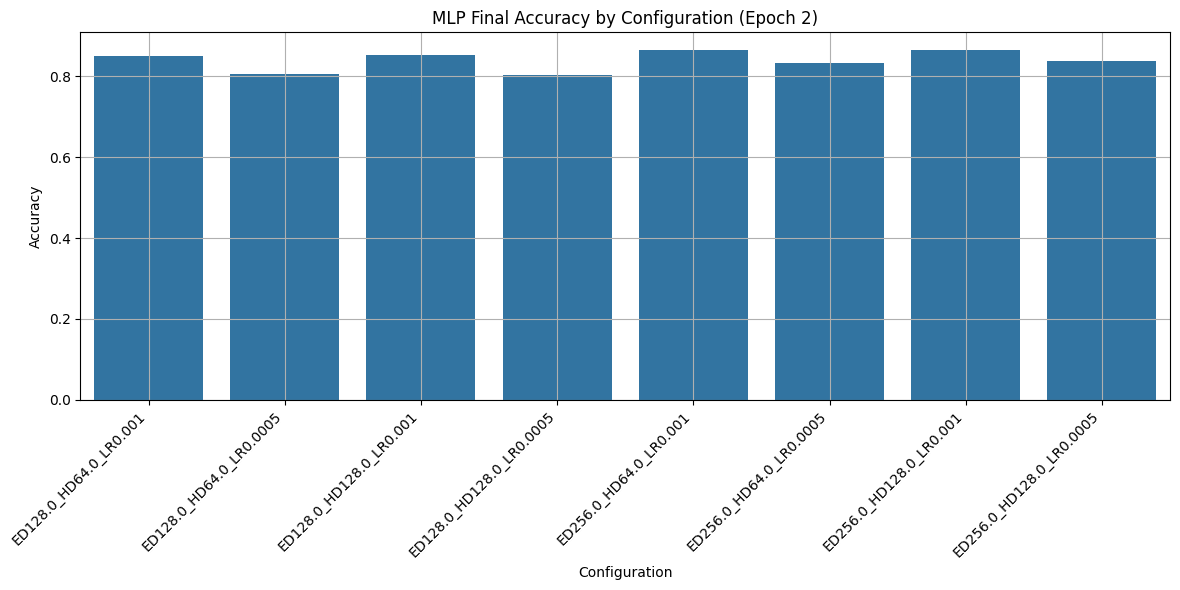

In [ ]:


# Step 1: Structure data
mlp_results = [
    (128, 64, 0.001, 0.8500),
    (128, 64, 0.0005, 0.8066),
    (128, 128, 0.001, 0.8518),
    (128, 128, 0.0005, 0.8044),
    (256, 64, 0.001, 0.8655),
    (256, 64, 0.0005, 0.8331),
    (256, 128, 0.001, 0.8648),
    (256, 128, 0.0005, 0.8385),
]


df_mlp = pd.DataFrame(mlp_results, columns=["embed_dim", "hidden_dim", "lr", "accuracy"])
df_mlp["config"] = df_mlp.apply(lambda r: f"ED{r.embed_dim}_HD{r.hidden_dim}_LR{r.lr}", axis=1)

# Step 2: Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=df_mlp, x="config", y="accuracy")
plt.xticks(rotation=45, ha='right')
plt.title("MLP Final Accuracy by Configuration (Epoch 2)")
plt.xlabel("Configuration")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.grid(True)
plt.show()

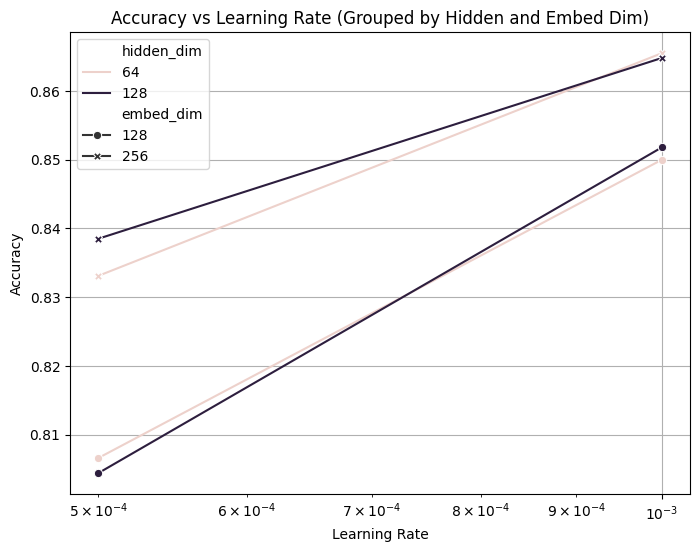

In [ ]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_mlp, x="lr", y="accuracy", hue="hidden_dim", style="embed_dim", markers=True, dashes=False)
plt.xscale("log")
plt.title("Accuracy vs Learning Rate (Grouped by Hidden and Embed Dim)")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
# Reload best model
final_mlp = MLPModel(len(vocab), best_params['embed_dim'], best_params['hidden_dim'], 2).to(device)
final_mlp.load_state_dict(torch.load('best_mlp_model.pth'))
final_mlp.eval()

MLPModel(
  (embedding): Embedding(7131, 256, padding_idx=0)
  (fc1): Linear(in_features=256, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

In [ ]:
def predict_twitter_sentiment(model, tweet, vocab, tokenizer, device):
    model.eval()
    tokens = tokenizer(tweet.lower())  # Lowercase for consistency
    indices = [vocab[token] if token in vocab else vocab['<unk>'] for token in tokens]
    indices = torch.tensor(indices).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(indices)
        pred = output.argmax(dim=1).item()

    return pred
for tweet in tweets:
    sentiment_pred = predict_twitter_sentiment(best_model, tweet, vocab, tokenizer, device)
    sentiment = "Positive" if sentiment_pred == 1 else "Negative"
    print(f"Tweet: {tweet}\nPrediction: {sentiment}\n")

Tweet: This phone exceeded all my expectations. Absolutely love it!
Prediction: Positive

Tweet: The food was cold and tasteless. Not coming back again.
Prediction: Negative

Tweet: Wow, waited 45 minutes for this masterpiece of disappointment.
Prediction: Positive

Tweet: The app crashed 3 times, but support fixed it quickly. Mixed feelings.
Prediction: Positive

Tweet: Nothing special about the movie. Just average.
Prediction: Positive

Tweet: Amazing product and super fast delivery. 10/10!
Prediction: Positive

Tweet: Sure, I love wasting my day in traffic. Best day ever!
Prediction: Positive

Tweet: Customer service was helpful, but I’m still not satisfied.
Prediction: Negative

Tweet: I’m so happy with my purchase, I’m telling everyone!
Prediction: Positive

Tweet: Yeah right, like that update really fixed anything.
Prediction: Positive



# AUTO ENCODER

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class AutoencoderClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, bottleneck_dim, hidden_dim, num_classes):
        super(AutoencoderClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(embed_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, bottleneck_dim)
        )

        # Decoder (can be ignored during classification)
        self.decoder = nn.Sequential(
            nn.Linear(bottleneck_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, embed_dim)
        )

        # Classifier head
        self.classifier = nn.Linear(bottleneck_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)           # [batch, seq_len, embed_dim]
        x = x.mean(dim=1)               # [batch, embed_dim]
        encoded = self.encoder(x)       # [batch, bottleneck_dim]
        logits = self.classifier(encoded)
        return logits

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_evaluate_autoencoder(embed_dim, bottleneck_dim, hidden_dim, learning_rate):
    model = AutoencoderClassifier(len(vocab), embed_dim, bottleneck_dim, hidden_dim, 2).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(2):
        model.train()
        total_loss, correct = 0, 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        avg_loss = total_loss / len(train_loader)
        accuracy = correct / len(train_dataset)
        print(f"[AE] Epoch {epoch+1}: Avg Loss = {avg_loss:.4f}, Accuracy = {accuracy:.4f}")

    # Evaluate
    model.eval()
    correct = 0
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            correct += (outputs.argmax(1) == labels).sum().item()

    test_accuracy = correct / len(test_dataset)
    return model, test_accuracy

# Hyperparameter grid
hyperparams = {
    'embed_dim': [128, 256],
    'bottleneck_dim': [32, 64],
    'hidden_dim': [64, 128],
    'learning_rate': [0.001, 0.0005]
}

best_accuracy = 0
best_model = None
best_params = {}

for embed_dim in hyperparams['embed_dim']:
    for bottleneck_dim in hyperparams['bottleneck_dim']:
        for hidden_dim in hyperparams['hidden_dim']:
            for lr in hyperparams['learning_rate']:
                print(f"Trying: embed_dim={embed_dim}, bottleneck_dim={bottleneck_dim}, hidden_dim={hidden_dim}, lr={lr}")
                model, acc = train_evaluate_autoencoder(embed_dim, bottleneck_dim, hidden_dim, lr)
                if acc > best_accuracy:
                    best_accuracy = acc
                    best_model = model
                    best_params = {
                        'embed_dim': embed_dim,
                        'bottleneck_dim': bottleneck_dim,
                        'hidden_dim': hidden_dim,
                        'learning_rate': lr
                    }
                    torch.save(model.state_dict(), 'best_autoencoder_model.pth')

print(f"\n✅ Best Autoencoder Accuracy: {best_accuracy:.4f} with params: {best_params}")




Trying: embed_dim=128, bottleneck_dim=32, hidden_dim=64, lr=0.001
[AE] Epoch 1: Avg Loss = 0.5275, Accuracy = 0.7197
[AE] Epoch 2: Avg Loss = 0.3484, Accuracy = 0.8494
Trying: embed_dim=128, bottleneck_dim=32, hidden_dim=64, lr=0.0005
[AE] Epoch 1: Avg Loss = 0.5961, Accuracy = 0.6684
[AE] Epoch 2: Avg Loss = 0.4297, Accuracy = 0.8047
Trying: embed_dim=128, bottleneck_dim=32, hidden_dim=128, lr=0.001
[AE] Epoch 1: Avg Loss = 0.5247, Accuracy = 0.7345
[AE] Epoch 2: Avg Loss = 0.3475, Accuracy = 0.8532
Trying: embed_dim=128, bottleneck_dim=32, hidden_dim=128, lr=0.0005
[AE] Epoch 1: Avg Loss = 0.5882, Accuracy = 0.6720
[AE] Epoch 2: Avg Loss = 0.4219, Accuracy = 0.8068
Trying: embed_dim=128, bottleneck_dim=64, hidden_dim=64, lr=0.001
[AE] Epoch 1: Avg Loss = 0.5226, Accuracy = 0.7320
[AE] Epoch 2: Avg Loss = 0.3451, Accuracy = 0.8499
Trying: embed_dim=128, bottleneck_dim=64, hidden_dim=64, lr=0.0005
[AE] Epoch 1: Avg Loss = 0.5853, Accuracy = 0.6694
[AE] Epoch 2: Avg Loss = 0.4161, Accur

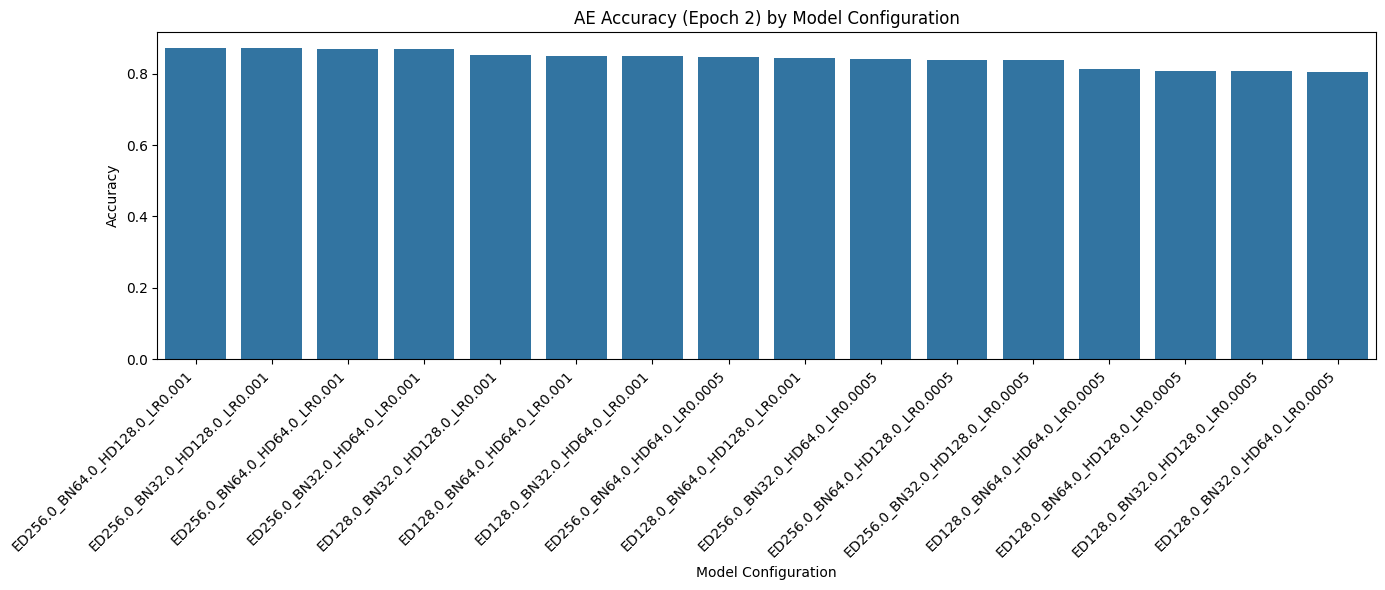

In [ ]:


# AE results
ae_results = [
    (128, 32, 64, 0.001, 0.8494),
    (128, 32, 64, 0.0005, 0.8047),
    (128, 32, 128, 0.001, 0.8532),
    (128, 32, 128, 0.0005, 0.8068),
    (128, 64, 64, 0.001, 0.8499),
    (128, 64, 64, 0.0005, 0.8148),
    (128, 64, 128, 0.001, 0.8452),
    (128, 64, 128, 0.0005, 0.8070),
    (256, 32, 64, 0.001, 0.8697),
    (256, 32, 64, 0.0005, 0.8416),
    (256, 32, 128, 0.001, 0.8719),
    (256, 32, 128, 0.0005, 0.8376),
    (256, 64, 64, 0.001, 0.8698),
    (256, 64, 64, 0.0005, 0.8464),
    (256, 64, 128, 0.001, 0.8728),
    (256, 64, 128, 0.0005, 0.8397),
]

df_ae = pd.DataFrame(ae_results, columns=["embed_dim", "bottleneck_dim", "hidden_dim", "lr", "accuracy"])
df_ae["config"] = df_ae.apply(lambda row: f"ED{row.embed_dim}_BN{row.bottleneck_dim}_HD{row.hidden_dim}_LR{row.lr}", axis=1)

# Plot
plt.figure(figsize=(14, 6))
sns.barplot(data=df_ae.sort_values("accuracy", ascending=False), x="config", y="accuracy")
plt.xticks(rotation=45, ha='right')
plt.title("AE Accuracy (Epoch 2) by Model Configuration")
plt.xlabel("Model Configuration")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

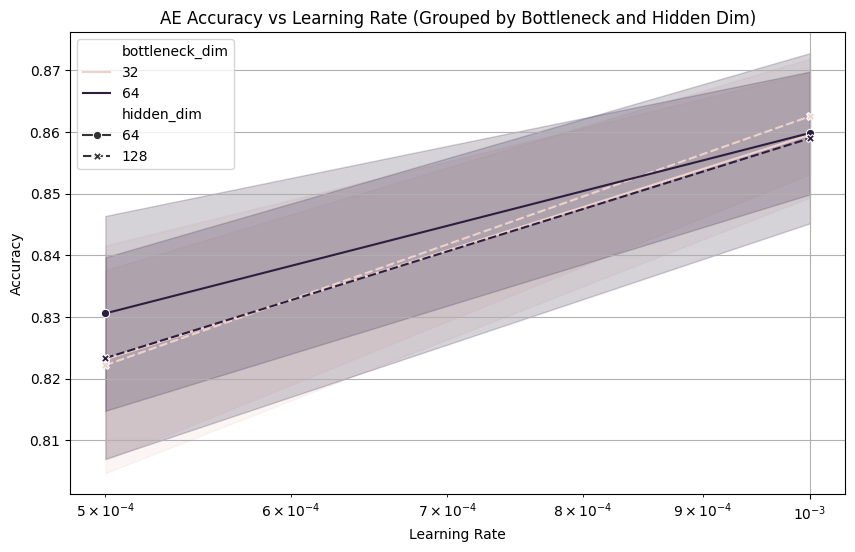

In [ ]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_ae, x="lr", y="accuracy", hue="bottleneck_dim", style="hidden_dim", markers=True)
plt.xscale("log")
plt.title("AE Accuracy vs Learning Rate (Grouped by Bottleneck and Hidden Dim)")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.grid(True)
plt.show()

In [ ]:
# Load best model
final_ae = AutoencoderClassifier(
    len(vocab),
    best_params['embed_dim'],
    best_params['bottleneck_dim'],
    best_params['hidden_dim'],
    2
).to(device)
final_ae.load_state_dict(torch.load('best_autoencoder_model.pth'))
final_ae.eval()

AutoencoderClassifier(
  (embedding): Embedding(7131, 256, padding_idx=0)
  (encoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=256, bias=True)
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)

In [ ]:
def predict_twitter_sentiment(model, tweet, vocab, tokenizer, device):
    model.eval()
    tokens = tokenizer(tweet.lower())  # Lowercase for consistency
    indices = [vocab[token] if token in vocab else vocab['<unk>'] for token in tokens]
    indices = torch.tensor(indices).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(indices)
        pred = output.argmax(dim=1).item()

    return pred

# Using final_ae (the best autoencoder model)
for tweet in tweets:
    sentiment_pred = predict_twitter_sentiment(final_ae, tweet, vocab, tokenizer, device)
    sentiment = "Positive" if sentiment_pred == 1 else "Negative"
    print(f"Tweet: {tweet}\nPrediction: {sentiment}\n")


Tweet: This phone exceeded all my expectations. Absolutely love it!
Prediction: Positive

Tweet: The food was cold and tasteless. Not coming back again.
Prediction: Negative

Tweet: Wow, waited 45 minutes for this masterpiece of disappointment.
Prediction: Positive

Tweet: The app crashed 3 times, but support fixed it quickly. Mixed feelings.
Prediction: Positive

Tweet: Nothing special about the movie. Just average.
Prediction: Positive

Tweet: Amazing product and super fast delivery. 10/10!
Prediction: Positive

Tweet: Sure, I love wasting my day in traffic. Best day ever!
Prediction: Positive

Tweet: Customer service was helpful, but I’m still not satisfied.
Prediction: Negative

Tweet: I’m so happy with my purchase, I’m telling everyone!
Prediction: Positive

Tweet: Yeah right, like that update really fixed anything.
Prediction: Positive



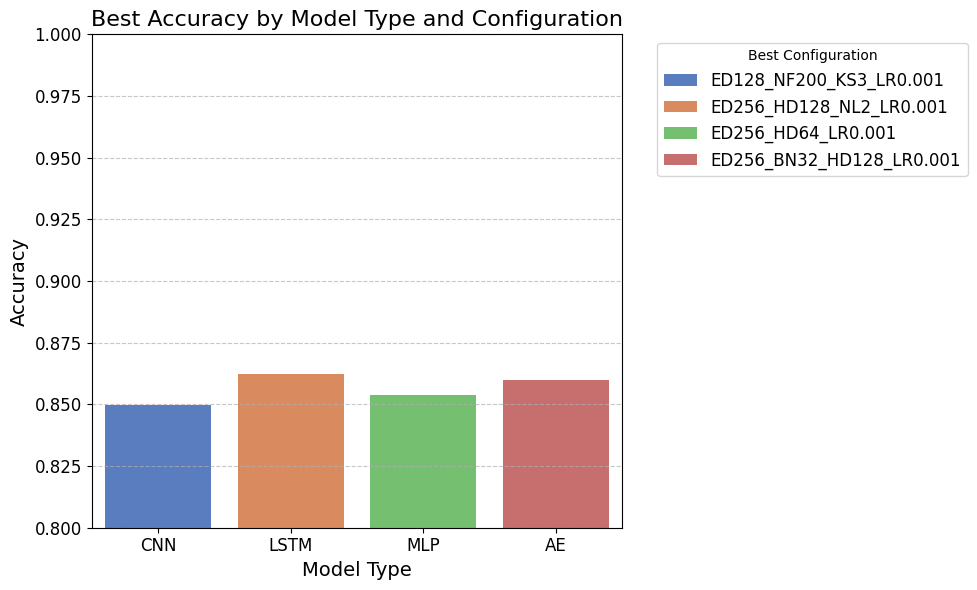

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

best_models = [
    ("CNN", 0.8497, "ED128_NF200_KS3_LR0.001"),
    ("LSTM", 0.8625, "ED256_HD128_NL2_LR0.001"),
    ("MLP", 0.8540, "ED256_HD64_LR0.001"),
    ("AE", 0.8598, "ED256_BN32_HD128_LR0.001")
]

df_best = pd.DataFrame(best_models, columns=["Model", "Accuracy", "Config"])

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=df_best, x="Model", y="Accuracy", hue="Config", palette='muted')

# Customize plot appearance
plt.ylim(0.8, 1.0)  # Adjusting the range where accuracy lies
plt.title("Best Accuracy by Model Type and Configuration", fontsize=16)
plt.ylabel("Accuracy", fontsize=14)
plt.xlabel("Model Type", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Improve the legend positioning
plt.legend(title="Best Configuration", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)

# Adjust layout to prevent clipping
plt.tight_layout()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()
